In [6]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import pickle

# --- Sklearn Imports (for Preprocessing, Splitting, and Metrics) ---
print("Loading standard utility libraries (sklearn, pandas, numpy)...")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer # CRITICAL for handling missing data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

# --- For 3D Plotting ---
from mpl_toolkits.mplot3d import Axes3D

# --- For Progress Bars ---
from tqdm.notebook import tqdm

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Matplotlib Setup ---
sns.set(style="whitegrid", palette="deep")

print("All libraries imported successfully.")

Loading standard utility libraries (sklearn, pandas, numpy)...
All libraries imported successfully.


In [7]:
# --- Configuration ---
# ❗ **ACTION REQUIRED**: Update this to the FULL, ABSOLUTE path to your code folder.
CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\MLProject\Classifier_codes'
# ---------------------

if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please update the path in this cell.")
else:
    # Add the folder to the system path to allow imports
    if CLASSIFIER_DIR not in sys.path:
        sys.path.append(os.path.abspath(CLASSIFIER_DIR))
    
    try:
        # Import all 9 of your classifier classes (and their dependencies)
        from KNN import KNN
        from LogisticRegression import LogisticRegression
        from DecisionTree import DecisionTreeClassifier, Node
        from RandomForest import RandomForestClassifier
        from SVM import LinearSVM
        from GaussianNaiveBayes import GaussianNaiveBayes
        from MultiLayerPerceptron import SimpleMLP
        from LinearDiscriminantAnalysis import LDA
        from AdaBoost import AdaBoost, DecisionStump, StumpNode
        
        print("✅ Successfully imported all 9 from-scratch classifiers.")
    except ImportError as e:
        print(f"--- 🛑 IMPORT ERROR ---\nError importing classifiers: {e}")
        print("Please check file/class names in your 'Classifier_codes' folder.")
    except Exception as e:
        print(f"An unexpected error occurred during import: {e}")

✅ Successfully imported all 9 from-scratch classifiers.


In [8]:
# This helper class is essential for LogReg, SVM, MLP, and AdaBoost.

class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.binary_le = LabelEncoder() # Use 0/1
        y_binary = self.binary_le.fit_transform(y)
        model = self.binary_classifier_class(**self.kwargs)
        model.fit(X, y_binary)
        self.models[self.binary_le.classes_[1]] = model 
    
    def predict(self, X):
        if hasattr(self, 'binary_le') and self.binary_le:
             # Binary case
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             return self.binary_le.inverse_transform(binary_preds)
        else:
            # Multi-class OvR case
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                if hasattr(model, 'predict_proba'):
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'):
                    all_scores.append(model.decision_function(X))
                else:
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

print("OvRWrapper class defined.")

OvRWrapper class defined.


In [9]:
# --- 1. Load Dataset from Text File and Convert to CSV ---
TXT_PATH = r"C:\Users\jaink\OneDrive\Desktop\MLProject\GallStone\test.txt"
CSV_PATH = r"C:\Users\jaink\OneDrive\Desktop\MLProject\GallStone\gallstone.csv"

print(f"Loading dataset from text file and converting to CSV...")
print(f"Text file: {TXT_PATH}")
print(f"CSV output: {CSV_PATH}")

if os.path.exists(TXT_PATH):
    try:
        # Read the text file (appears to be tab-separated)
        print("Reading text file...")
        df = pd.read_csv(TXT_PATH, sep='\t', encoding='utf-8')
        print(f"✅ Successfully loaded text file!")
        print(f"   Shape: {df.shape}")
        
        # Save as CSV for future use
        df.to_csv(CSV_PATH, index=False, encoding='utf-8')
        print(f"✅ Successfully converted to CSV!")
        print(f"   CSV saved at: {CSV_PATH}")
        
    except Exception as e:
        # Try different encodings and separators
        print(f"Initial attempt failed: {e}")
        print("Trying alternative approaches...")
        
        encodings_to_try = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        separators_to_try = ['\t', ',', ';', '|']
        
        df = None
        for encoding in encodings_to_try:
            for sep in separators_to_try:
                try:
                    print(f"  Trying encoding: {encoding}, separator: '{sep}'")
                    df = pd.read_csv(TXT_PATH, sep=sep, encoding=encoding)
                    if df.shape[1] > 1:  # Check if we got multiple columns
                        print(f"  ✅ Success with encoding: {encoding}, separator: '{sep}'")
                        # Save as CSV
                        df.to_csv(CSV_PATH, index=False, encoding='utf-8')
                        print(f"  ✅ CSV saved at: {CSV_PATH}")
                        break
                except Exception:
                    continue
            if df is not None and df.shape[1] > 1:
                break
        
        if df is None or df.shape[1] <= 1:
            raise ValueError("Could not read the text file with any encoding/separator combination")
        
else:
    print(f"❌ Text file not found at: {TXT_PATH}")
    # List files in the directory to help debug
    directory = os.path.dirname(TXT_PATH)
    if os.path.exists(directory):
        print(f"\n📁 Files in {directory}:")
        for file in os.listdir(directory):
            print(f"  - {file}")
    raise FileNotFoundError(f"Text file not found: {TXT_PATH}")

# If we successfully loaded the data, continue with processing
if 'df' in locals() and df is not None:
    print(f"\n--- Data Processing ---")
    print(f"Original shape: {df.shape}")
    print(f"Original columns: {list(df.columns)}")
    
    # --- 2. Clean Column Names ---
    print("\nCleaning column names...")
    # Remove parentheses, %, (Kg), and replace spaces with underscores
    df.columns = df.columns.str.replace(r'[\(\)%]', '', regex=True).str.strip().str.replace(' ', '_')
    
    # Fix specific column names
    df.columns = df.columns.str.replace('Gallstone_Status', 'Gallstone_Status')
    df.columns = df.columns.str.replace('Coronary_Artery_Disease_CAD', 'Coronary_Artery_Disease_CAD')
    df.columns = df.columns.str.replace('Diabetes_Mellitus_DM', 'Diabetes_Mellitus_DM')
    
    print(f"Cleaned columns: {list(df.columns)}")
    
    # --- 3. Initial Data Cleaning ---
    print("\nPerforming initial data cleaning...")
    
    # Convert numeric columns
    numeric_cols = []
    for col in df.columns:
        if col not in ['Gender'] and df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                numeric_cols.append(col)
            except:
                pass
    
    print(f"Converted {len(numeric_cols)} columns to numeric")
    
    # Handle Gender column - convert to binary (0=Female, 1=Male if needed)
    if 'Gender' in df.columns:
        unique_genders = df['Gender'].unique()
        print(f"Unique Gender values: {unique_genders}")
        
        # If Gender is already 0/1, convert to category
        if set(unique_genders).issubset({0, 1, '0', '1'}):
            df['Gender'] = df['Gender'].astype('category')
        else:
            # Map text values to binary if needed
            gender_map = {'F': 0, 'Female': 0, 'M': 1, 'Male': 1}
            df['Gender'] = df['Gender'].map(gender_map).fillna(df['Gender'])
            df['Gender'] = df['Gender'].astype('category')
        
        print(f"Gender column processed")
    
    print(f"\n✅ Dataset loaded and cleaned successfully!")
    print(f"Final shape: {df.shape}")
    print(f"Data types:")
    print(df.dtypes)
    
    print("\n--- First 5 rows ---")
    print(df.head())
    
    print("\n--- Missing Values Summary ---")
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        print(missing_summary[missing_summary > 0])
    else:
        print("No missing values found!")
        
else:
    raise ValueError("Failed to load the dataset")

Loading dataset from text file and converting to CSV...
Text file: C:\Users\jaink\OneDrive\Desktop\MLProject\GallStone\test.txt
CSV output: C:\Users\jaink\OneDrive\Desktop\MLProject\GallStone\gallstone.csv
Reading text file...
✅ Successfully loaded text file!
   Shape: (319, 39)
✅ Successfully converted to CSV!
   CSV saved at: C:\Users\jaink\OneDrive\Desktop\MLProject\GallStone\gallstone.csv

--- Data Processing ---
Original shape: (319, 39)
Original columns: ['Gallstone Status', 'Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Vis

--- Missing Value Check ---
Gallstone_Status                                0
High_Density_Lipoprotein_HDL                    0
Total_Fat_Content_TFC                           0
Visceral_Fat_Area_VFA                           0
Visceral_Muscle_Area_VMA_Kg                     0
Hepatic_Fat_Accumulation_HFA                    0
Glucose                                         0
Total_Cholesterol_TC                            0
Low_Density_Lipoprotein_LDL                     0
Triglyceride                                    0
Muscle_Mass_MM                                  0
Aspartat_Aminotransferaz_AST                    0
Alanin_Aminotransferaz_ALT                      0
Alkaline_Phosphatase_ALP                        0
Creatinine                                      0
Glomerular_Filtration_Rate_GFR                  0
C-Reactive_Protein_CRP                          0
Hemoglobin_HGB                                  0
Obesity                                         0
Bone_Mass_BM          

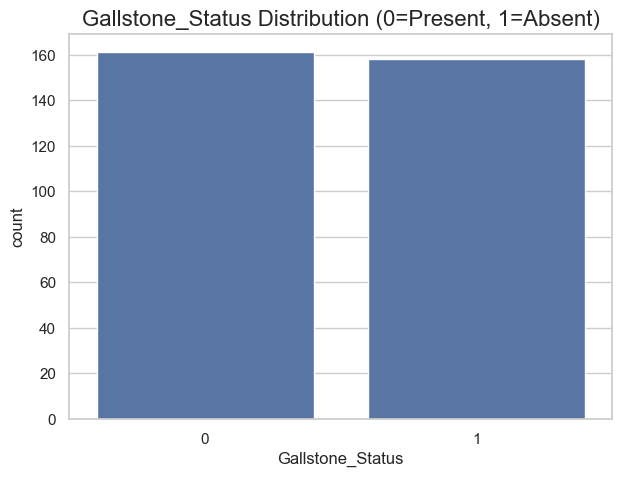

In [10]:
TARGET = 'Gallstone_Status'

print("--- Missing Value Check ---")
print(df.isnull().sum().sort_values(ascending=False))

# --- Target Distribution ---
plt.figure(figsize=(7, 5))
sns.countplot(x=TARGET, data=df)
plt.title(f'{TARGET} Distribution (0=Present, 1=Absent)', fontsize=16)
plt.show()

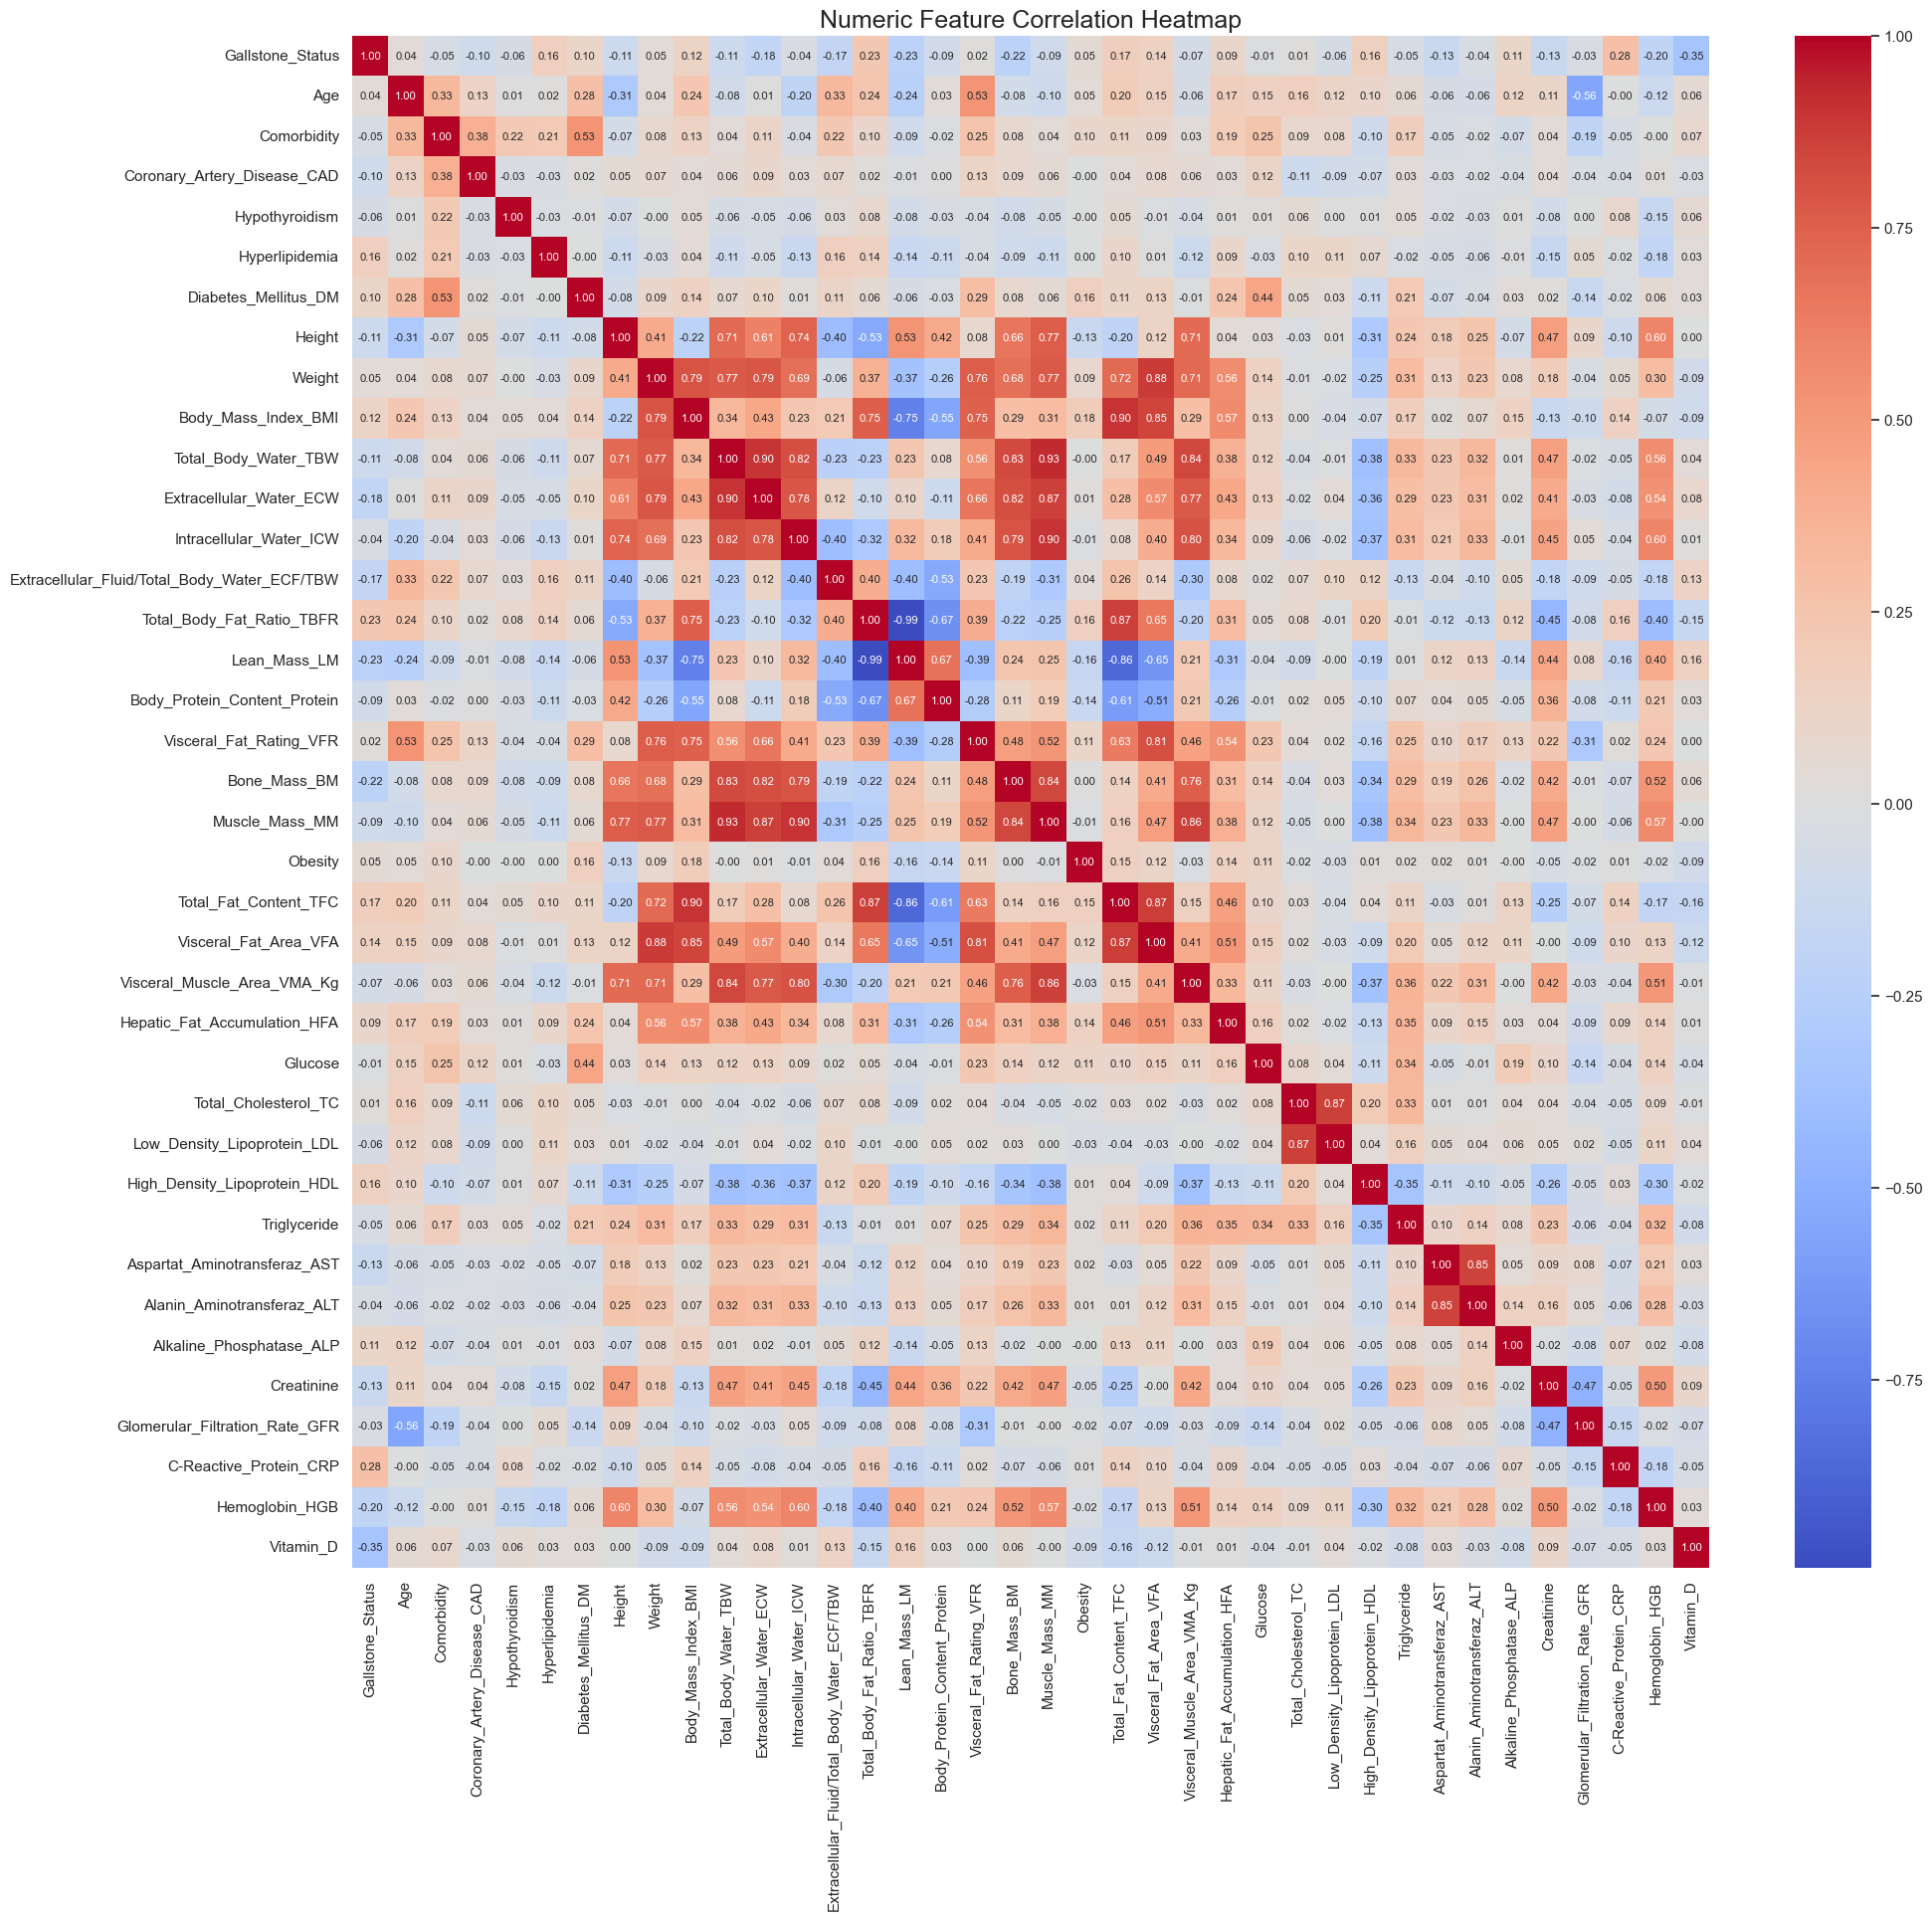

In [11]:
# --- Correlation Heatmap ---
# We'll drop non-numeric columns and calculate correlation
df_numeric = df.select_dtypes(include=np.number)

plt.figure(figsize=(22, 20))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})
plt.title('Numeric Feature Correlation Heatmap', fontsize=18)
plt.show()

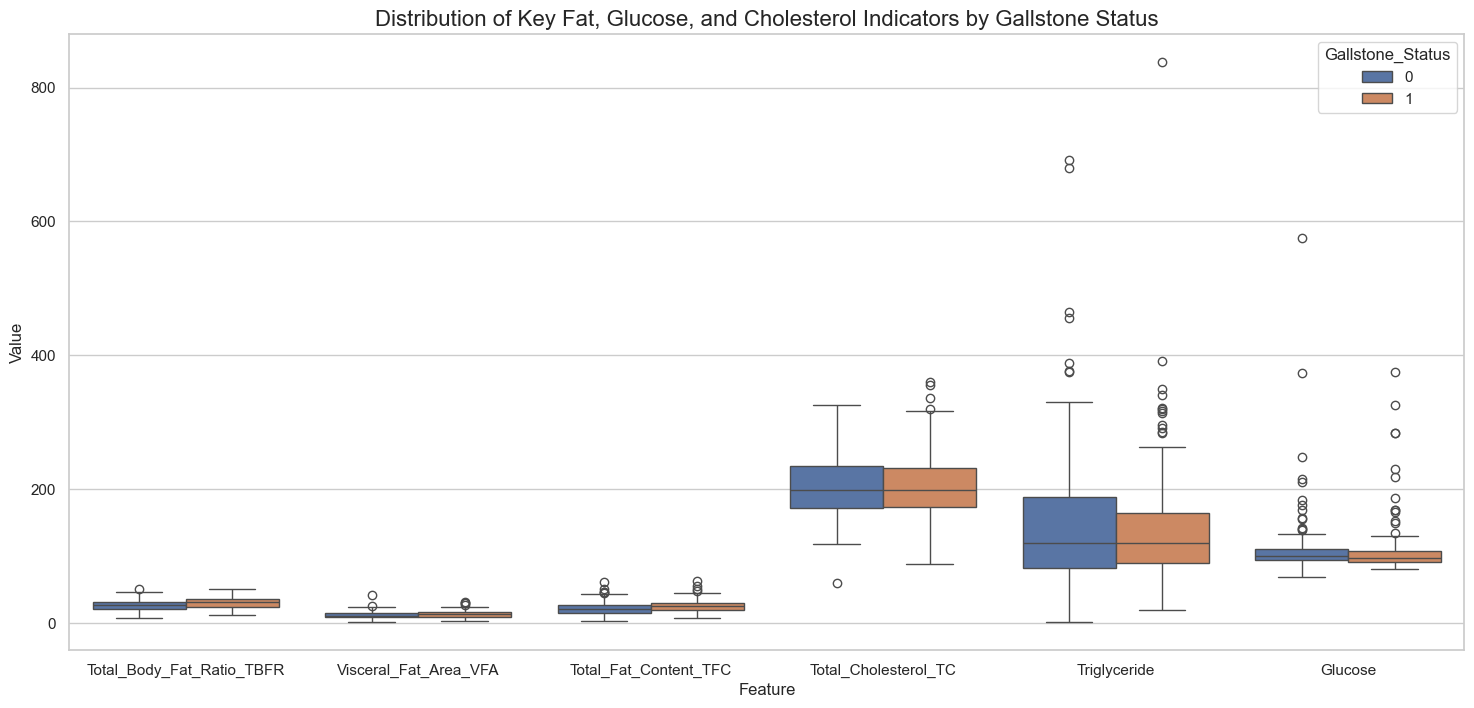

In [12]:
# Top features highly correlated with Gallstone Status
top_fat_cols = ['Total_Body_Fat_Ratio_TBFR', 'Visceral_Fat_Area_VFA', 'Total_Fat_Content_TFC', 
                'Total_Cholesterol_TC', 'Triglyceride', 'Glucose']

df_melt = df.melt(id_vars=TARGET, value_vars=top_fat_cols, var_name='Feature', value_name='Value')

plt.figure(figsize=(18, 8))
sns.boxplot(x='Feature', y='Value', hue=TARGET, data=df_melt)
plt.title('Distribution of Key Fat, Glucose, and Cholesterol Indicators by Gallstone Status', fontsize=16)
plt.show()

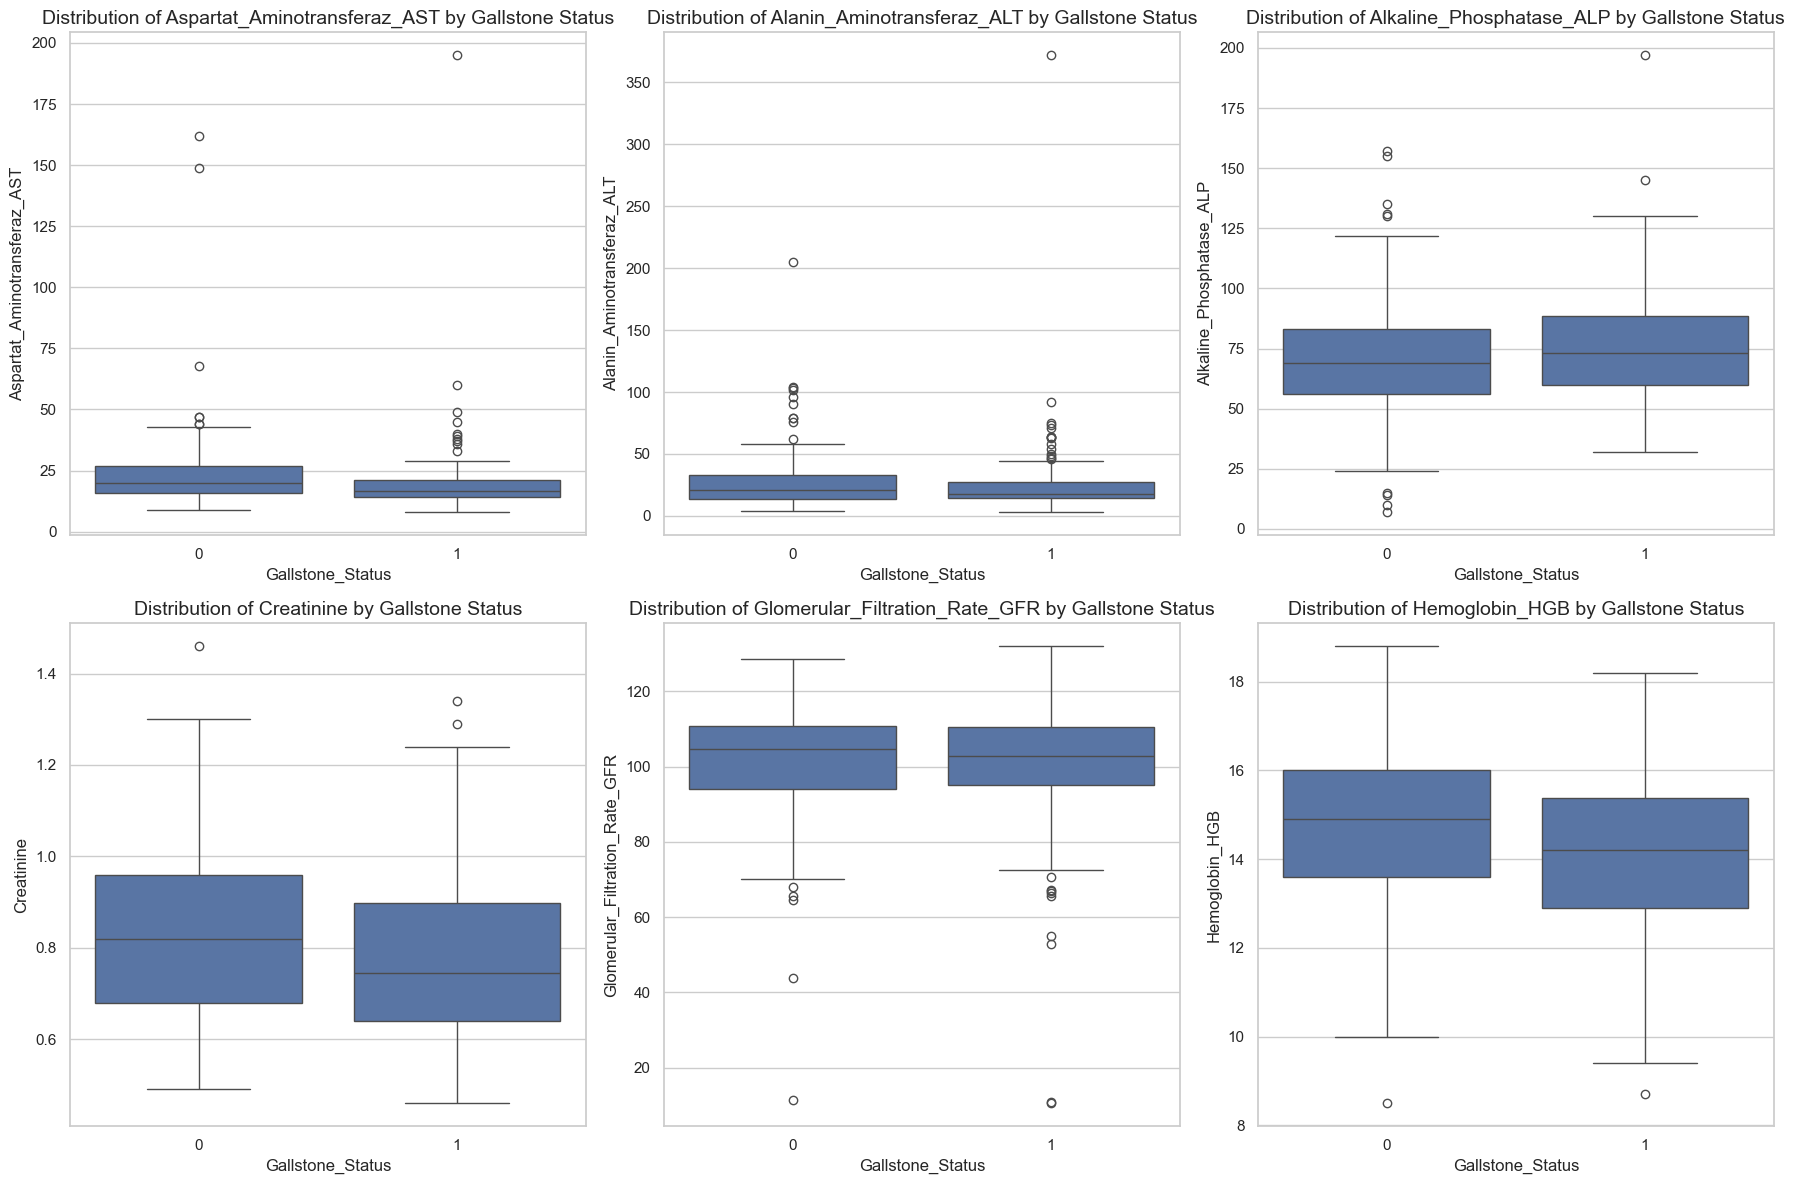

In [13]:
# Liver Enzymes and Kidney Markers
health_cols = ['Aspartat_Aminotransferaz_AST', 'Alanin_Aminotransferaz_ALT', 
               'Alkaline_Phosphatase_ALP', 'Creatinine', 'Glomerular_Filtration_Rate_GFR', 'Hemoglobin_HGB']

plt.figure(figsize=(18, 12))
for i, col in enumerate(health_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=TARGET, y=col, data=df)
    plt.title(f'Distribution of {col} by Gallstone Status', fontsize=14)

plt.tight_layout()
plt.show()

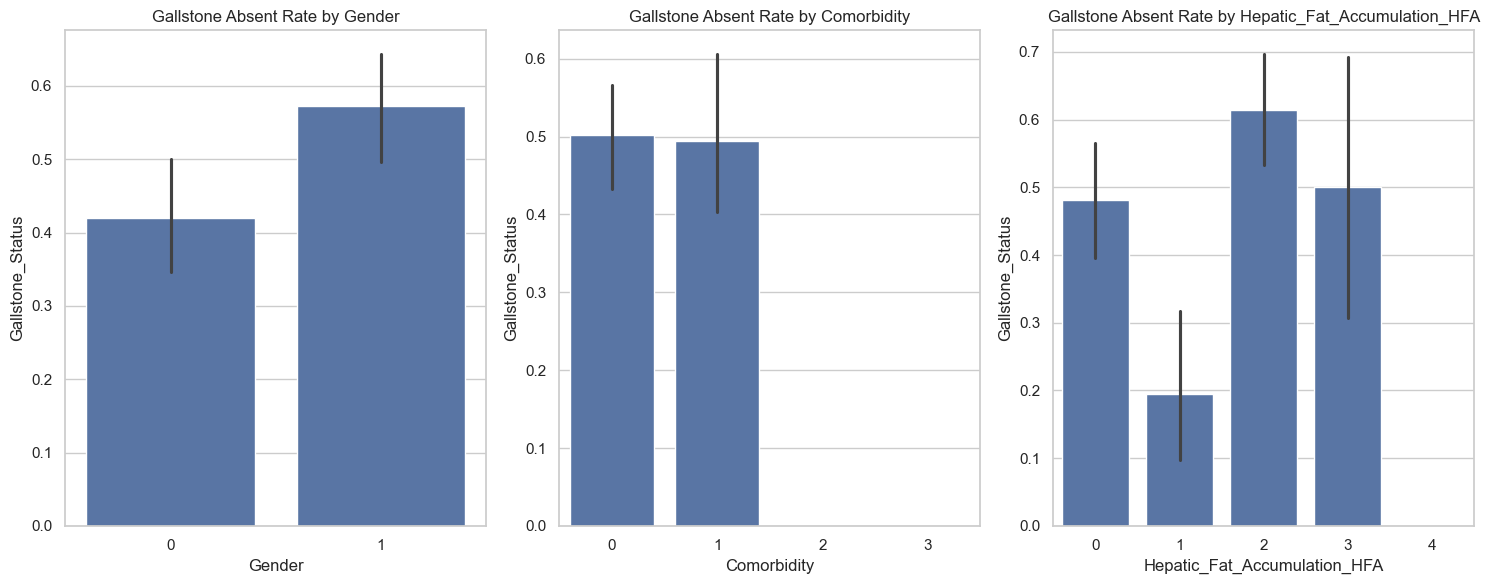

In [14]:
# Comorbidity and HFA are the primary categorical health factors
categorical_rate_cols = ['Gender', 'Comorbidity', 'Hepatic_Fat_Accumulation_HFA']

plt.figure(figsize=(15, 6))
for i, col in enumerate(categorical_rate_cols):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=col, y=TARGET, data=df)
    plt.title(f'Gallstone Absent Rate by {col}', fontsize=12)

plt.tight_layout()
plt.show()

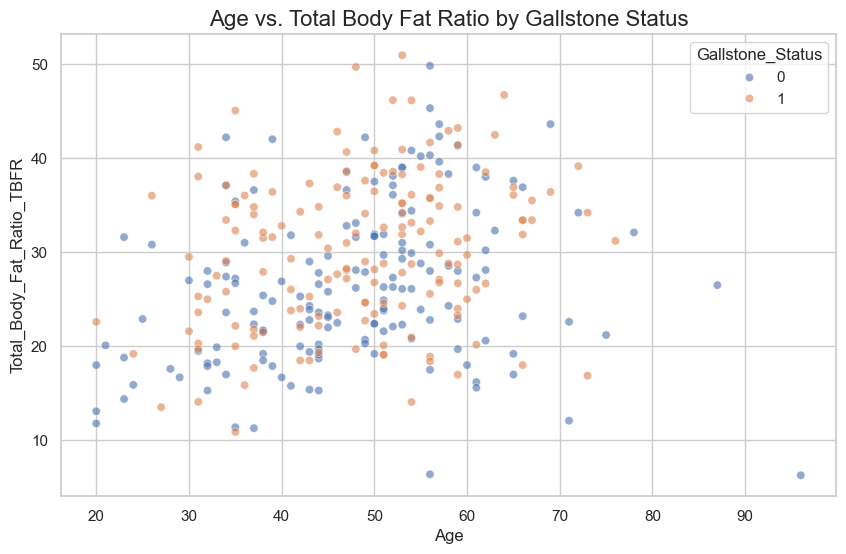

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Total_Body_Fat_Ratio_TBFR', hue=TARGET, data=df, alpha=0.6)
plt.title('Age vs. Total Body Fat Ratio by Gallstone Status', fontsize=16)
plt.show()

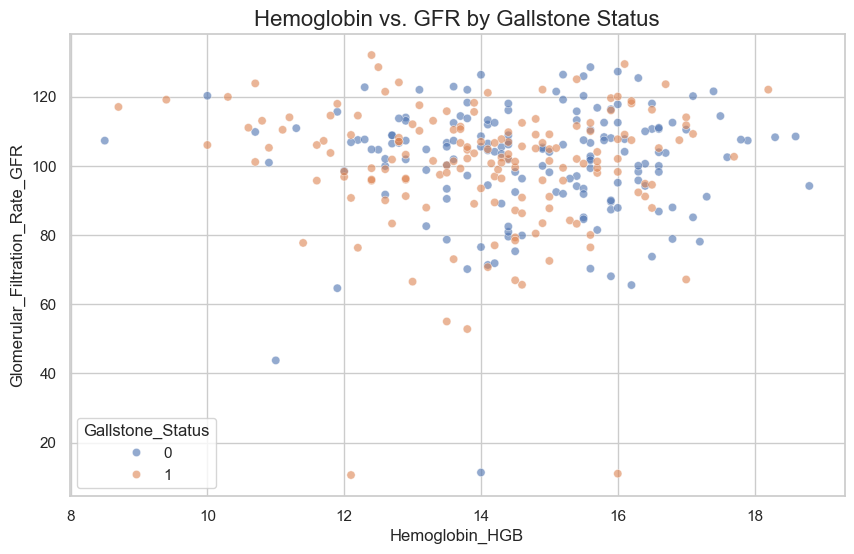

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Hemoglobin_HGB', y='Glomerular_Filtration_Rate_GFR', hue=TARGET, data=df, alpha=0.6)
plt.title('Hemoglobin vs. GFR by Gallstone Status', fontsize=16)
plt.show()

In [17]:
# --- Define X (features) and y (target) ---
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# CRITICAL: Imputation is handled in the pipeline, but if the initial data had NaNs, 
# we need to be mindful if any Y values were missing (though none were in the example data).
initial_rows = len(X)
X = X.dropna(subset=['Hypothyroidism', 'Hyperlipidemia', 'Diabetes_Mellitus_DM', 'Gender']) # Dropping known binary NaNs if they exist
y = y.loc[X.index]
print(f"Dropped {initial_rows - len(X)} rows with missing categorical/target values.")

# We use stratify=y because the dataset is imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Dropped 0 rows with missing categorical/target values.

X_train shape: (255, 38)
X_test shape: (64, 38)


In [18]:
# --- Define Feature Lists (Updated to match actual column names) ---
print("Checking actual column names in dataset...")
print(f"Available columns: {list(X.columns)}")

# All features that are continuous, integer, or binary that need scaling
NUMERIC_FEATURES = [
    'Age', 'Height', 'Weight', 'Body_Mass_Index_BMI', 'Total_Body_Water_TBW', 
    'Extracellular_Water_ECW', 'Intracellular_Water_ICW', 'Extracellular_Fluid/Total_Body_Water_ECF/TBW', 
    'Total_Body_Fat_Ratio_TBFR', 'Lean_Mass_LM', 'Body_Protein_Content_Protein', 
    'Visceral_Fat_Rating_VFR', 'Bone_Mass_BM', 'Muscle_Mass_MM', 'Obesity', 
    'Total_Fat_Content_TFC', 'Visceral_Fat_Area_VFA', 'Visceral_Muscle_Area_VMA_Kg', 
    'Glucose', 'Total_Cholesterol_TC', 'Low_Density_Lipoprotein_LDL', 
    'High_Density_Lipoprotein_HDL', 'Triglyceride', 'Aspartat_Aminotransferaz_AST', 
    'Alanin_Aminotransferaz_ALT', 'Alkaline_Phosphatase_ALP', 'Creatinine', 
    'Glomerular_Filtration_Rate_GFR', 'C-Reactive_Protein_CRP', 'Hemoglobin_HGB', 
    'Vitamin_D', 'Coronary_Artery_Disease_CAD', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes_Mellitus_DM' # Binary but treated as scaled numeric
]

# True Categorical/Ordinal features that need OHE
CATEGORICAL_FEATURES = ['Gender', 'Comorbidity', 'Hepatic_Fat_Accumulation_HFA']

# Filter features to only include those that actually exist in the dataset
existing_numeric_features = [f for f in NUMERIC_FEATURES if f in X.columns]
existing_categorical_features = [f for f in CATEGORICAL_FEATURES if f in X.columns]

print(f"\nFiltered NUMERIC_FEATURES ({len(existing_numeric_features)} features):")
for f in existing_numeric_features:
    print(f"  - {f}")

print(f"\nFiltered CATEGORICAL_FEATURES ({len(existing_categorical_features)} features):")
for f in existing_categorical_features:
    print(f"  - {f}")

# Update the feature lists to use only existing features
NUMERIC_FEATURES = existing_numeric_features
CATEGORICAL_FEATURES = existing_categorical_features

# --- Create Preprocessing Pipelines ---

# Pipeline for NUMERIC data: Impute (mean) -> Scale (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for CATEGORICAL data: Impute (most frequent) -> One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- Create the Full ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='drop'
)

# --- Apply the Pipeline ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- Define the final feature count for MLP input ---
n_features_final = X_train_processed.shape[1]

# --- Convert y to numpy arrays ---
y_train_np = y_train.values
y_test_np = y_test.values

print(f"Preprocessing complete. Final feature count: {n_features_final}")

Checking actual column names in dataset...
Available columns: ['Age', 'Gender', 'Comorbidity', 'Coronary_Artery_Disease_CAD', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes_Mellitus_DM', 'Height', 'Weight', 'Body_Mass_Index_BMI', 'Total_Body_Water_TBW', 'Extracellular_Water_ECW', 'Intracellular_Water_ICW', 'Extracellular_Fluid/Total_Body_Water_ECF/TBW', 'Total_Body_Fat_Ratio_TBFR', 'Lean_Mass_LM', 'Body_Protein_Content_Protein', 'Visceral_Fat_Rating_VFR', 'Bone_Mass_BM', 'Muscle_Mass_MM', 'Obesity', 'Total_Fat_Content_TFC', 'Visceral_Fat_Area_VFA', 'Visceral_Muscle_Area_VMA_Kg', 'Hepatic_Fat_Accumulation_HFA', 'Glucose', 'Total_Cholesterol_TC', 'Low_Density_Lipoprotein_LDL', 'High_Density_Lipoprotein_HDL', 'Triglyceride', 'Aspartat_Aminotransferaz_AST', 'Alanin_Aminotransferaz_ALT', 'Alkaline_Phosphatase_ALP', 'Creatinine', 'Glomerular_Filtration_Rate_GFR', 'C-Reactive_Protein_CRP', 'Hemoglobin_HGB', 'Vitamin_D']

Filtered NUMERIC_FEATURES (35 features):
  - Age
  - Height
  - Weight
  

In [19]:
# --- Define Model Pipeline ---
print("Defining all 9 from-scratch classifier models...")

# Define the models using "Better Accuracy" parameters
multi_class_models = {
    "KNN": KNN(k=5),
    "GNB": GaussianNaiveBayes(),
    "LDA": LDA(),
    "DT": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "RF": RandomForestClassifier(n_trees=100, max_depth=10, min_samples_split=5),
}

# Binary models wrapped in OvR
binary_models_to_wrap = {
    "LogReg_OvR": (LogisticRegression, 
                   {"learning_rate": 0.01, "n_iters": 1000, "verbose": False}),
    "SVM_OvR": (LinearSVM, 
                {"learning_rate": 0.001, "lambda_param": 0.01, "verbose": False}),
    "MLP_OvR": (SimpleMLP, 
                {"n_input": n_features_final, "n_hidden": 32, "n_output": 1,
                 "learning_rate": 0.01, "n_iters": 1000, "verbose": False, 
                 "activation": 'relu'}),
    "AdaBoost_OvR": (AdaBoost, {"n_estimators": 50}),
}

# --- Combine the dictionaries ---
all_models = multi_class_models.copy()
for name, (model_class, kwargs) in binary_models_to_wrap.items():
    all_models[name] = OvRWrapper(model_class, **kwargs)
    
print(f"Total models to train: {len(all_models)}")

Defining all 9 from-scratch classifier models...
Total models to train: 9


In [20]:
# --- Run All Models ---
results = {}
reports = {}
models_trained = {} 

print("\n--- Running Model Benchmarks on Processed Data ---")

for name, model in tqdm(all_models.items(), desc="Overall Model Progress"):
    try:
        start_time = time.time()
        
        # Determine which data to use (scaled for linear/NN, unscaled for trees/GNB)
        if name in ["KNN", "LDA", "LogReg_OvR", "SVM_OvR", "MLP_OvR"]:
            X_tr, X_te = X_train_processed, X_test_processed
        else:
            X_tr, X_te = X_train_processed, X_test_processed
            
        # Train the model
        model.fit(X_tr, y_train_np)
        
        # Predict
        y_pred = model.predict(X_te)
        
        duration = time.time() - start_time
        acc = accuracy_score(y_test_np, y_pred)
        
        # Generate report as a dictionary for later use
        report_dict = classification_report(y_test_np, y_pred, target_names=['Present (0)', 'Absent (1)'], output_dict=True, zero_division=0)
        
        results[name] = acc
        reports[name] = report_dict
        models_trained[name] = model
    
    except Exception as e:
        import traceback
        print(f"  ❌ ERROR training/predicting with {name}: {e}")
        traceback.print_exc() 
        results[name] = 0.0
        reports[name] = str(e)

print("\nAll models trained and evaluated.")


--- Running Model Benchmarks on Processed Data ---


Overall Model Progress:   0%|          | 0/9 [00:00<?, ?it/s]

KNN fitted with 255 samples.
Predicting for 64 samples using KNN (k=5)...
Fitting Gaussian Naive Bayes...
Fitting complete.
Predicting labels for 64 samples using GNB...
Fitting LDA...
LDA fitting complete.
Predicting labels for 64 samples using LDA...
Fitting Decision Tree: max_depth=10, min_split=5, features_per_split=46...
Tree fitting complete.
Predicting labels for 64 samples using Decision Tree...
Fitting Random Forest: 100 trees, max_depth=10, min_split=5, features_per_split=6...
  Tree 10/100 fitted.
  Tree 20/100 fitted.
  Tree 30/100 fitted.
  Tree 40/100 fitted.
  Tree 50/100 fitted.
  Tree 60/100 fitted.
  Tree 70/100 fitted.
  Tree 80/100 fitted.
  Tree 90/100 fitted.
  Tree 100/100 fitted.
Random Forest fitting complete.
Predicting labels for 64 samples using Random Forest (100 trees)...
Starting Logistic Regression training for up to 1000 iterations (alpha=0.01)...
Convergence reached at iteration 649. Cost = 0.474352
Predicting labels for 64 samples using Logistic Regre

In [21]:
# --- Final Results Summary ---

print("\n\n" + "="*30)
print("🏁 FINAL ACCURACY SUMMARY 🏁")
print("="*30 + "\n")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Format accuracy as percentage
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")

print(results_df.to_string())



🏁 FINAL ACCURACY SUMMARY 🏁

          Model Accuracy
0            RF   82.81%
1  AdaBoost_OvR   82.81%
2           LDA   79.69%
3    LogReg_OvR   79.69%
4       MLP_OvR   76.56%
5       SVM_OvR   75.00%
6           KNN   70.31%
7            DT   62.50%
8           GNB   54.69%


In [22]:
# --- Best Model Classification Report ---

# Get the name and accuracy of the best model (re-sorting by number)
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n\n--- 🏆 Best Model ---")
print(f"{best_model_name} (Accuracy: {best_accuracy})")

# --- Print Classification Report for the Best Model ---
print("\n--- Classification Report for Best Model ---")
best_report_dict = reports[best_model_name]
if isinstance(best_report_dict, dict):
    best_report_df = pd.DataFrame(best_report_dict).transpose()
    print(best_report_df)
else:
    print(best_report_dict)



--- 🏆 Best Model ---
RF (Accuracy: 82.81%)

--- Classification Report for Best Model ---
              precision    recall  f1-score    support
Present (0)    0.800000  0.875000  0.835821  32.000000
Absent (1)     0.862069  0.781250  0.819672  32.000000
accuracy       0.828125  0.828125  0.828125   0.828125
macro avg      0.831034  0.828125  0.827747  64.000000
weighted avg   0.831034  0.828125  0.827747  64.000000


Predicting labels for 64 samples using Random Forest (100 trees)...


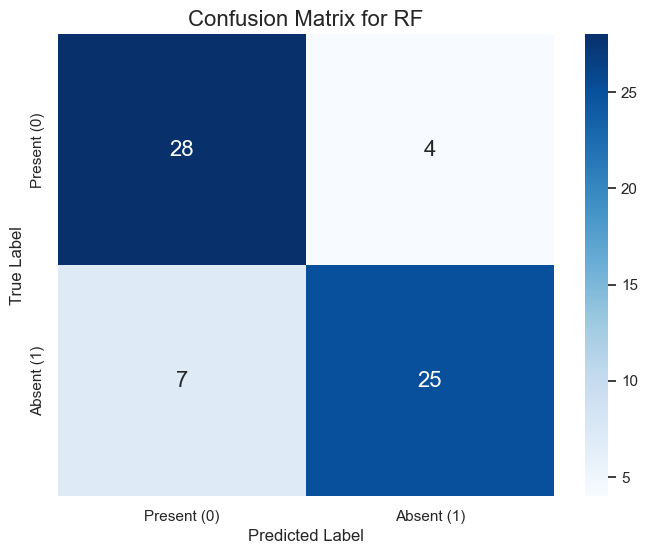

In [23]:
# --- Confusion Matrix for Best Model ---

# Determine the correct test data
if best_model_name in ["KNN", "LDA", "LogReg_OvR", "SVM_OvR", "MLP_OvR"]:
    X_test_for_prediction = X_test_processed
else:
    X_test_for_prediction = X_test_processed

# The best model's predictions:
best_model_instance = models_trained[best_model_name]
y_pred_best_enc = best_model_instance.predict(X_test_for_prediction)

# Convert string labels for plotting
plot_labels = ['Present (0)', 'Absent (1)']

cm = confusion_matrix(y_test_np, y_pred_best_enc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=plot_labels, 
            yticklabels=plot_labels,
            annot_kws={"size": 16})
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()